In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_csv("flight_delay_modeling_data.csv")
df.head()

,Month,DayOfWeek,IsWeekend,Season,Year,DepTime,CRSDepTime,CRSArrTime,Distance,Reporting_Airline,...,OriginLowVisibility,DestLowVisibility,origin_temp_c,dest_temp_c,origin_visibility_m,dest_visibility_m,Route,ArrDelay,ArrDel15,ArrDel30
0,1,1,0,1,2018,37.0,45,702,2075.0,AA,...,0,0,16.1,-12.2,16093.0,16093.0,PHX-PHL,-12.0,0.0,0
1,1,1,0,1,2018,557.0,600,804,666.0,AA,...,0,0,-3.3,-12.8,16000.0,16093.0,ATL-PHL,-27.0,0.0,0
2,1,1,0,1,2018,818.0,830,959,335.0,OH,...,0,0,-17.2,-12.8,16093.0,16093.0,CAK-PHL,1.0,0.0,0
3,1,1,0,1,2018,720.0,700,1017,814.0,YX,...,0,0,-18.3,-12.8,16093.0,16093.0,STL-PHL,14.0,0.0,0
4,1,1,0,1,2018,846.0,848,1026,280.0,B6,...,0,0,-17.2,-12.8,16000.0,16093.0,BOS-PHL,-19.0,0.0,0


In [ ]:
df.shape

(2163033, 22)

In [ ]:
df.columns

Index(['Month', 'DayOfWeek', 'IsWeekend', 'Season', 'Year', 'DepTime',
       'CRSDepTime', 'CRSArrTime', 'Distance', 'Reporting_Airline', 'Origin',
       'Dest', 'OriginLowVisibility', 'DestLowVisibility', 'origin_temp_c',
       'dest_temp_c', 'origin_visibility_m', 'dest_visibility_m', 'Route',
       'ArrDelay', 'ArrDel15', 'ArrDel30'],
      dtype='object')

In [ ]:
def feature_engineer_cyclical(df):
    df_eng = df.copy()

    # --- 1. Month (1-12) ---
    df_eng['Month_sin'] = np.sin(2 * np.pi * df_eng['Month'] / 12)
    df_eng['Month_cos'] = np.cos(2 * np.pi * df_eng['Month'] / 12)

    # --- 2. DayOfWeek (1-7) ---
    df_eng['DayOfWeek_sin'] = np.sin(2 * np.pi * df_eng['DayOfWeek'] / 7)
    df_eng['DayOfWeek_cos'] = np.cos(2 * np.pi * df_eng['DayOfWeek'] / 7)

    # --- 3. Times (HHMM -> Minutes) ---
    # Helper to convert HHMM to minutes (e.g., 630 -> 390, 2359 -> 1439)
    def to_minutes(x):
        return (x // 100) * 60 + (x % 100)

    # Dep Time
    dep_mins = df_eng['CRSDepTime'].apply(to_minutes)
    df_eng['CRSDepTime_sin'] = np.sin(2 * np.pi * dep_mins / 1440)
    df_eng['CRSDepTime_cos'] = np.cos(2 * np.pi * dep_mins / 1440)

    # Arr Time
    arr_mins = df_eng['CRSArrTime'].apply(to_minutes)
    df_eng['CRSArrTime_sin'] = np.sin(2 * np.pi * arr_mins / 1440)
    df_eng['CRSArrTime_cos'] = np.cos(2 * np.pi * arr_mins / 1440)

    return df_eng

# Apply the transformation
df = feature_engineer_cyclical(df)

In [ ]:
df.head()

,Month,DayOfWeek,IsWeekend,Season,Year,DepTime,CRSDepTime,CRSArrTime,Distance,Reporting_Airline,...,ArrDel15,ArrDel30,Month_sin,Month_cos,DayOfWeek_sin,DayOfWeek_cos,CRSDepTime_sin,CRSDepTime_cos,CRSArrTime_sin,CRSArrTime_cos
0,1,1,0,1,2018,37.0,45,702,2075.0,AA,...,0.0,0,0.5,0.866025,0.781831,0.62349,0.195090,9.807853e-01,0.963630,-0.267238
1,1,1,0,1,2018,557.0,600,804,666.0,AA,...,0.0,0,0.5,0.866025,0.781831,0.62349,1.000000,6.123234e-17,0.857167,-0.515038
2,1,1,0,1,2018,818.0,830,959,335.0,OH,...,0.0,0,0.5,0.866025,0.781831,0.62349,0.793353,-6.087614e-01,0.503774,-0.863836
3,1,1,0,1,2018,720.0,700,1017,814.0,YX,...,0.0,0,0.5,0.866025,0.781831,0.62349,0.965926,-2.588190e-01,0.434445,-0.900698
4,1,1,0,1,2018,846.0,848,1026,280.0,B6,...,0.0,0,0.5,0.866025,0.781831,0.62349,0.743145,-6.691306e-01,0.398749,-0.917060


In [ ]:
# Drop leakage columns if present
leak_cols = ["ArrDelay", "ArrDel30"]  # adjust based on dataset
df = df.drop(columns=[col for col in leak_cols if col in df.columns])

redundant_cols = ["Route"]
df = df.drop(columns=[col for col in redundant_cols if col in df.columns])

# Define target
target = "ArrDel15"
y = df[target]
X = df.drop(columns=[target])

# ---- DROP DepTime HERE ----
if "DepTime" in X.columns:
    X = X.drop(columns=["DepTime"])
# ----------------------------

X.head()

,Month,DayOfWeek,IsWeekend,Season,Year,CRSDepTime,CRSArrTime,Distance,Reporting_Airline,Origin,...,origin_visibility_m,dest_visibility_m,Month_sin,Month_cos,DayOfWeek_sin,DayOfWeek_cos,CRSDepTime_sin,CRSDepTime_cos,CRSArrTime_sin,CRSArrTime_cos
0,1,1,0,1,2018,45,702,2075.0,AA,PHX,...,16093.0,16093.0,0.5,0.866025,0.781831,0.62349,0.195090,9.807853e-01,0.963630,-0.267238
1,1,1,0,1,2018,600,804,666.0,AA,ATL,...,16000.0,16093.0,0.5,0.866025,0.781831,0.62349,1.000000,6.123234e-17,0.857167,-0.515038
2,1,1,0,1,2018,830,959,335.0,OH,CAK,...,16093.0,16093.0,0.5,0.866025,0.781831,0.62349,0.793353,-6.087614e-01,0.503774,-0.863836
3,1,1,0,1,2018,700,1017,814.0,YX,STL,...,16093.0,16093.0,0.5,0.866025,0.781831,0.62349,0.965926,-2.588190e-01,0.434445,-0.900698
4,1,1,0,1,2018,848,1026,280.0,B6,BOS,...,16000.0,16093.0,0.5,0.866025,0.781831,0.62349,0.743145,-6.691306e-01,0.398749,-0.917060


In [ ]:
df.columns

Index(['Month', 'DayOfWeek', 'IsWeekend', 'Season', 'Year', 'DepTime',
       'CRSDepTime', 'CRSArrTime', 'Distance', 'Reporting_Airline', 'Origin',
       'Dest', 'OriginLowVisibility', 'DestLowVisibility', 'origin_temp_c',
       'dest_temp_c', 'origin_visibility_m', 'dest_visibility_m', 'ArrDel15',
       'Month_sin', 'Month_cos', 'DayOfWeek_sin', 'DayOfWeek_cos',
       'CRSDepTime_sin', 'CRSDepTime_cos', 'CRSArrTime_sin', 'CRSArrTime_cos'],
      dtype='object')

In [ ]:
y.head()

,ArrDel15
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [ ]:
# # df = df[(df['Origin'] == 'AUS') | (df['Dest'] == 'AUS')]
# # df = df[(df['Origin'] == 'AUS')]
# df = df[(df['Dest'] == 'AUS')]
# df.shape

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# 1. Define Column Groups based on your input
cat_cols = ['Reporting_Airline', 'Origin', 'Dest', 'IsWeekend', 'Season', 'Year']
# cat_cols = ['Reporting_Airline', 'IsWeekend', 'Season', 'Year']
# Removing DepTime (potential leakage) and Target. Using columns from X.head()

# Updated Continuous Columns
cont_cols = [
    'Distance', 'OriginLowVisibility',
    'DestLowVisibility', 'origin_temp_c', 'dest_temp_c',
    'origin_visibility_m', 'dest_visibility_m',
    # New Cyclical Features:
    'Month_sin', 'Month_cos',
    'DayOfWeek_sin', 'DayOfWeek_cos',
    'CRSDepTime_sin', 'CRSDepTime_cos',
    'CRSArrTime_sin', 'CRSArrTime_cos'
]

# We removed 'Month', 'DayOfWeek', 'CRSDepTime', 'CRSArrTime' from inputs
# because the sin/cos pairs now represent them.

target_col = 'ArrDel15'

# Assuming 'df' is your loaded DataFrame
# Handle missing values (simple imputation for demonstration)
df = df.dropna(subset=[target_col])
df[cont_cols] = df[cont_cols].fillna(0)

# 2. Encode Categoricals (Strings -> Ints)
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# 3. Scale Continuous Variables (Important for Neural Nets)
scaler = StandardScaler()
df[cont_cols] = scaler.fit_transform(df[cont_cols])

# 4. Split Data
X = df[cat_cols + cont_cols]
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
class FlightDataset(Dataset):
    def __init__(self, X, y, cat_cols, cont_cols):
        self.X_cat = torch.tensor(X[cat_cols].values, dtype=torch.long)
        self.X_cont = torch.tensor(X[cont_cols].values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X_cat[idx], self.X_cont[idx], self.y[idx]

# Create DataLoaders
train_dataset = FlightDataset(X_train, y_train, cat_cols, cont_cols)
test_dataset = FlightDataset(X_test, y_test, cat_cols, cont_cols)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
class FlightDelayMLP(nn.Module):
    def __init__(self, embedding_sizes, n_cont, out_sz=1, layers=[256, 128, 64, 32], p=0.5):
        super().__init__()

        # 1. Create Embedding Layers for Categoricals
        self.embeddings = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in embedding_sizes])
        self.emb_drop = nn.Dropout(p)
        self.n_emb = sum(nf for ni, nf in embedding_sizes)

        # 2. Build the MLP layers
        self.n_cont = n_cont
        n_in = self.n_emb + self.n_cont

        layerlist = []
        for i in layers:
            layerlist.append(nn.Linear(n_in, i))
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i

        layerlist.append(nn.Linear(layers[-1], out_sz))

        self.layers = nn.Sequential(*layerlist)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x_cat, x_cont):
        # Process embeddings
        embeddings = [e(x_cat[:, i]) for i, e in enumerate(self.embeddings)]
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)

        # Concatenate with continuous variables
        x = torch.cat([x, x_cont], 1)

        # Pass through MLP
        x = self.layers(x)
        return self.sigmoid(x)

In [ ]:
# # Calculate embedding sizes: [(num_unique_categories, embedding_dim), ...]
# cat_dims = [len(label_encoders[col].classes_) for col in cat_cols]
# embedding_sizes = [(c, min(50, (c + 1) // 2)) for c in cat_dims]

# # Initialize Model
# model = FlightDelayMLP(embedding_sizes, n_cont=len(cont_cols))
# criterion = nn.BCELoss() # Binary Cross Entropy for binary classification
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# # Training Loop
# epochs = 5
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

# print(f"Training on {device}...")

# for i in range(epochs):
#     print(f"Epoch {i+1}/{epochs}")
#     model.train()
#     total_loss = 0
#     for x_cat, x_cont, y_target in train_loader:
#         x_cat, x_cont, y_target = x_cat.to(device), x_cont.to(device), y_target.to(device)

#         optimizer.zero_grad()
#         y_pred = model(x_cat, x_cont)
#         loss = criterion(y_pred, y_target)
#         loss.backward()
#         optimizer.step()

#         total_loss += loss.item()

#     print(f"Epoch {i+1}/{epochs} - Loss: {total_loss/len(train_loader):.4f}")


In [ ]:
import copy
from sklearn.model_selection import train_test_split

# 1. Create a Validation Split (e.g., 20% of the training data)
# Assuming X_train and y_train are your current training inputs
X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

# 2. Create DataLoaders for both sets
# We use the FlightDataset class defined previously
train_ds = FlightDataset(X_train_sub, y_train_sub, cat_cols, cont_cols)
val_ds = FlightDataset(X_val, y_val, cat_cols, cont_cols)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False)

# 3. Setup Model & Optimization
cat_dims = [len(label_encoders[col].classes_) for col in cat_cols]
embedding_sizes = [(c, min(50, (c + 1) // 2)) for c in cat_dims]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FlightDelayMLP(embedding_sizes, n_cont=len(cont_cols))
model.to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# --- EARLY STOPPING SETTINGS ---
patience = 5             # How many epochs to wait after last improvement
min_delta = 0.0001       # Min change to count as an improvement
best_val_loss = float('inf')
counter = 0
best_model_wts = copy.deepcopy(model.state_dict())
max_epochs = 50          # Set high, relies on early stopping to exit

print(f"Starting training with Early Stopping (Patience={patience})...")

for i in range(max_epochs):
    # --- A. Training Phase ---
    model.train()
    train_loss = 0
    for x_cat, x_cont, y_target in train_loader:
        x_cat, x_cont, y_target = x_cat.to(device), x_cont.to(device), y_target.to(device)

        optimizer.zero_grad()
        y_pred = model(x_cat, x_cont)
        loss = criterion(y_pred, y_target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)

    # --- B. Validation Phase ---
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x_cat, x_cont, y_target in val_loader:
            x_cat, x_cont, y_target = x_cat.to(device), x_cont.to(device), y_target.to(device)
            y_pred = model(x_cat, x_cont)
            loss = criterion(y_pred, y_target)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch {i+1}/{max_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}", end=" ")

    # --- C. Early Stopping Logic ---
    # Check if validation loss improved
    if avg_val_loss < (best_val_loss - min_delta):
        print(f"--> Improved (Saved)")
        best_val_loss = avg_val_loss
        best_model_wts = copy.deepcopy(model.state_dict()) # Save the best weights
        counter = 0 # Reset patience counter
    else:
        counter += 1
        print(f"| No improve ({counter}/{patience})")

        if counter >= patience:
            print(f"\nEarly stopping triggered! Validation loss hasn't improved for {patience} epochs.")
            print(f"Restoring best weights from loss: {best_val_loss:.4f}")
            model.load_state_dict(best_model_wts) # Load the best model, not the last one
            break

Starting training with Early Stopping (Patience=5)...
Epoch 1/50 | Train Loss: 0.4676 | Val Loss: 0.4525 --> Improved! (Saved)
Epoch 2/50 | Train Loss: 0.4582 | Val Loss: 0.4515 --> Improved! (Saved)
Epoch 3/50 | Train Loss: 0.4565 | Val Loss: 0.4501 --> Improved! (Saved)
Epoch 4/50 | Train Loss: 0.4556 | Val Loss: 0.4504 | No improve (1/5)
Epoch 5/50 | Train Loss: 0.4550 | Val Loss: 0.4486 --> Improved! (Saved)
Epoch 6/50 | Train Loss: 0.4543 | Val Loss: 0.4490 | No improve (1/5)
Epoch 7/50 | Train Loss: 0.4540 | Val Loss: 0.4479 --> Improved! (Saved)
Epoch 8/50 | Train Loss: 0.4537 | Val Loss: 0.4479 | No improve (1/5)
Epoch 9/50 | Train Loss: 0.4533 | Val Loss: 0.4470 --> Improved! (Saved)
Epoch 10/50 | Train Loss: 0.4528 | Val Loss: 0.4464 --> Improved! (Saved)
Epoch 11/50 | Train Loss: 0.4529 | Val Loss: 0.4471 | No improve (1/5)
Epoch 12/50 | Train Loss: 0.4526 | Val Loss: 0.4468 | No improve (2/5)
Epoch 13/50 | Train Loss: 0.4525 | Val Loss: 0.4463 | No improve (3/5)
Epoch 14/50

In [ ]:
# Simple Evaluation
model.eval()
correct = 0
with torch.no_grad():
    for x_cat, x_cont, y_target in test_loader:
        x_cat, x_cont, y_target = x_cat.to(device), x_cont.to(device), y_target.to(device)
        output = model(x_cat, x_cont)
        predicted = (output > 0.5).float()
        correct += (predicted == y_target).sum().item()

print(f"Accuracy: {correct / len(test_dataset):.4f}")

Accuracy: 0.8159


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import numpy as np

model.eval()
y_true_list = []
y_prob_list = []

print("Evaluating model...")

with torch.no_grad():
    for x_cat, x_cont, y_target in test_loader:
        # Move to device
        x_cat = x_cat.to(device)
        x_cont = x_cont.to(device)
        y_target = y_target.to(device)

        # Forward pass (Get probabilities)
        output = model(x_cat, x_cont)

        # Store results (Move to CPU and convert to numpy)
        # .ravel() flattens (batch_size, 1) -> (batch_size,)
        y_prob_list.append(output.cpu().numpy())
        y_true_list.append(y_target.cpu().numpy())

# 1. Concatenate all batches into single arrays
y_true = np.concatenate(y_true_list).ravel()
y_probs = np.concatenate(y_prob_list).ravel()

# 2. Convert probabilities to class predictions (Threshold = 0.5)
y_pred = (y_probs > 0.5).astype(int)

# 3. Calculate Metrics
accuracy = np.mean(y_pred == y_true)
precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)
roc_auc = roc_auc_score(y_true, y_probs)

# 4. Print Results
print("-" * 30)
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}  (How many predicted delays were actual delays?)")
print(f"Recall:    {recall:.4f}  (How many actual delays did we catch?)")
print(f"F1 Score:  {f1:.4f}  (Harmonic mean of Prec/Recall)")
print(f"ROC-AUC:   {roc_auc:.4f}  (Ability to distinguish classes)")
print("-" * 30)

# 5. Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(f"TN: {cm[0][0]} | FP: {cm[0][1]}")
print(f"FN: {cm[1][0]} | TP: {cm[1][1]}")

Evaluating model...
------------------------------
Accuracy:  0.8159
Precision: 0.5865  (How many predicted delays were actual delays?)
Recall:    0.0217  (How many actual delays did we catch?)
F1 Score:  0.0419  (Harmonic mean of Prec/Recall)
ROC-AUC:   0.6871  (Ability to distinguish classes)
------------------------------
Confusion Matrix:
TN: 351237 | FP: 1228
FN: 78400 | TP: 1742


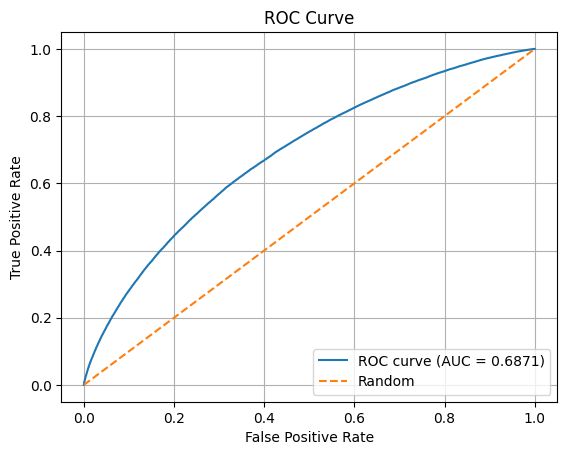

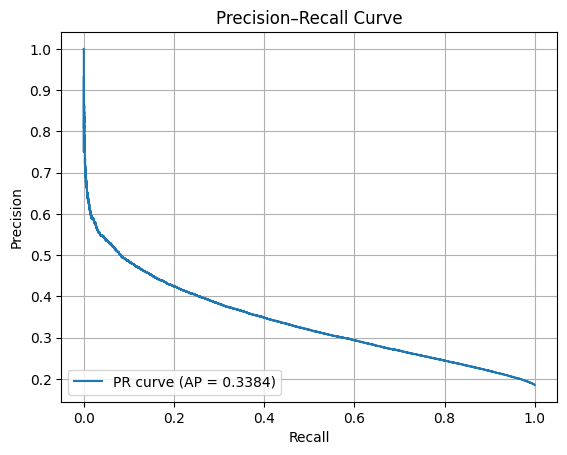

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, average_precision_score

# --- ROC Curve ---
fpr, tpr, roc_thresholds = roc_curve(y_true, y_probs)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# --- Precision-Recall Curve ---
prec, rec, pr_thresholds = precision_recall_curve(y_true, y_probs)
avg_prec = average_precision_score(y_true, y_probs)

plt.figure()
plt.plot(rec, prec, label=f"PR curve (AP = {avg_prec:.4f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

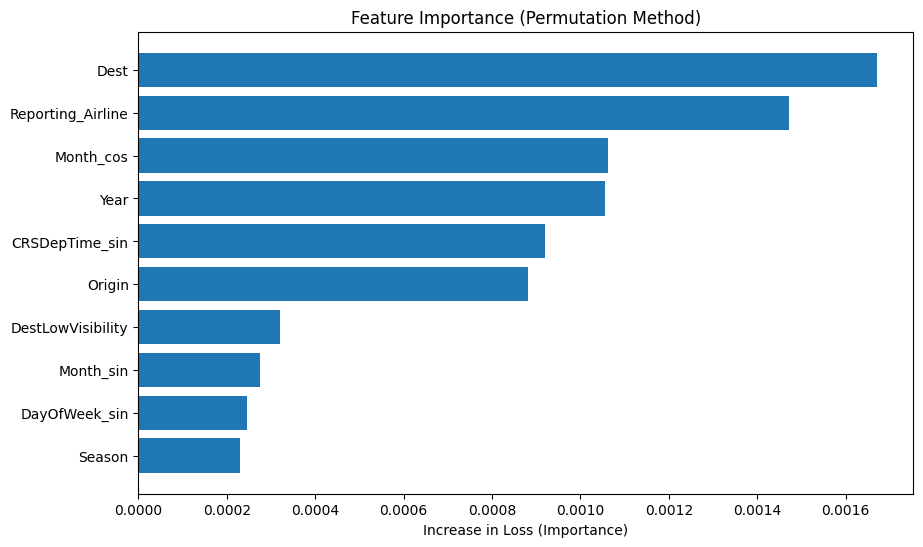

In [ ]:
import matplotlib.pyplot as plt

import numpy as np
import torch
import torch.nn as nn

def get_permutation_importance(model, X_cat, X_cont, y_true, cat_cols, cont_cols, device, use_logits=True):
    model.eval()

    # pick correct loss
    criterion = nn.BCEWithLogitsLoss() if use_logits else nn.BCELoss()

    # --- coerce inputs ---
    # categorical must be a DataFrame-like (so we can permute by column name)
    X_cat_df = X_cat.copy()

    # continuous -> numpy array (n, p)
    X_cont_np = X_cont.values if hasattr(X_cont, "values") else np.asarray(X_cont)

    # tensors for baseline
    with torch.no_grad():
        x_cat_tensor = torch.tensor(X_cat_df.values, dtype=torch.long, device=device)
        x_cont_tensor = torch.tensor(X_cont_np, dtype=torch.float32, device=device)
        y_tensor = torch.tensor(
            (y_true.values if hasattr(y_true, "values") else np.asarray(y_true)),
            dtype=torch.float32,
            device=device
        ).reshape(-1, 1)

        baseline_out = model(x_cat_tensor, x_cont_tensor)  # logits or probs depending on model
        original_loss = criterion(baseline_out, y_tensor).item()

    feature_importance = {}

    # --- permute categorical ---
    for col in cat_cols:
        X_cat_perm = X_cat_df.copy()
        X_cat_perm[col] = np.random.permutation(X_cat_perm[col].to_numpy())

        with torch.no_grad():
            x_cat_perm_tensor = torch.tensor(X_cat_perm.values, dtype=torch.long, device=device)
            out_perm = model(x_cat_perm_tensor, x_cont_tensor)
            loss_perm = criterion(out_perm, y_tensor).item()

        feature_importance[col] = loss_perm - original_loss

    # --- permute continuous ---
    for j, col in enumerate(cont_cols):
        X_cont_perm = X_cont_np.copy()
        X_cont_perm[:, j] = np.random.permutation(X_cont_perm[:, j])

        with torch.no_grad():
            x_cont_perm_tensor = torch.tensor(X_cont_perm, dtype=torch.float32, device=device)
            out_perm = model(x_cat_tensor, x_cont_perm_tensor)
            loss_perm = criterion(out_perm, y_tensor).item()

        feature_importance[col] = loss_perm - original_loss

    return feature_importance

importances = get_permutation_importance(
    model,
    X_test[cat_cols],
    X_test[cont_cols],   # pass DF or .values; both work now
    y_test,
    cat_cols,
    cont_cols,
    device=device,
    use_logits=True      # set False only if model output is already sigmoid probs
)

# Plotting
sorted_imp = dict(sorted(importances.items(), key=lambda item: item[1], reverse=True))
plt.figure(figsize=(10, 6))
plt.barh(list(sorted_imp.keys())[:10], list(sorted_imp.values())[:10]) # Top 10
plt.xlabel("Increase in Loss (Importance)")
plt.title("Feature Importance (Permutation Method)")
plt.gca().invert_yaxis()
plt.show()

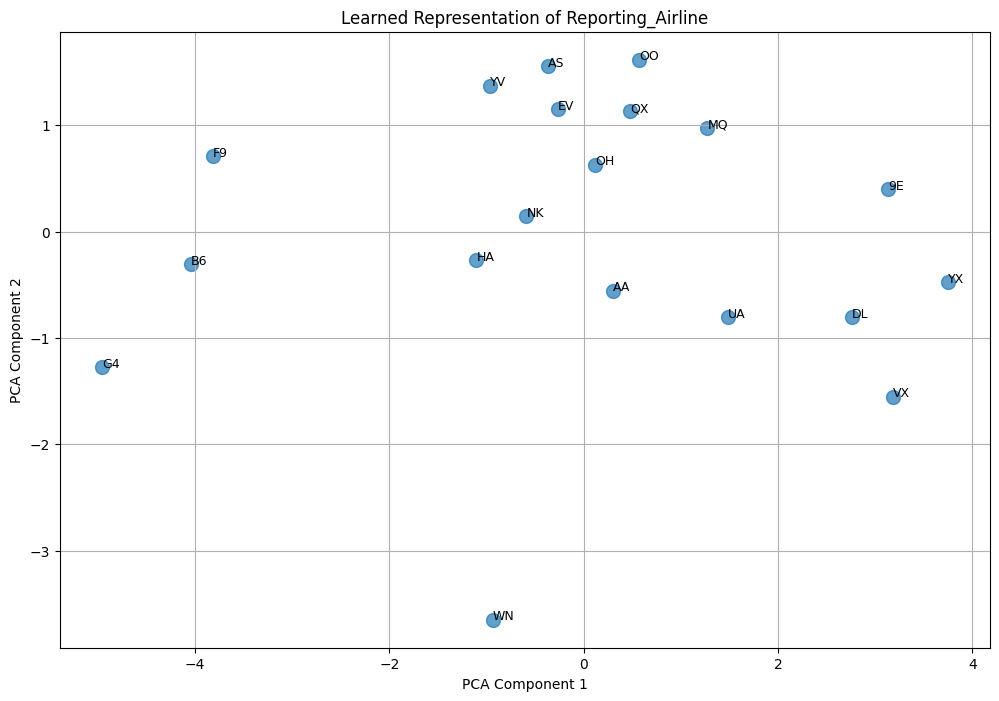

In [ ]:
from sklearn.decomposition import PCA

def plot_embeddings(model, le, col_name, emb_layer_idx):
    # 1. Extract weights from the specific embedding layer
    # emb_layer_idx depends on the order in cat_cols.
    # If Reporting_Airline was first, idx is 0.
    weights = model.embeddings[emb_layer_idx].weight.detach().cpu().numpy()

    # 2. Reduce dimensions to 2D using PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(weights)

    # 3. Plot
    plt.figure(figsize=(12, 8))
    plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.7, s=100)

    # 4. Annotate points with Airline names
    classes = le.classes_ # The original string labels
    for i, label in enumerate(classes):
        # Only plot if indices are within range (safety check)
        if i < len(pca_result):
            plt.text(pca_result[i, 0], pca_result[i, 1], label, fontsize=9)

    plt.title(f"Learned Representation of {col_name}")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.grid(True)
    plt.show()

# Assuming 'Reporting_Airline' is the 0th item in cat_cols
plot_embeddings(model, label_encoders['Reporting_Airline'], 'Reporting_Airline', 0)

### MLP trained by year

In [ ]:
# 1. Global Categorical Encoding (To keep indices consistent across years)
df_all = df.copy() # Assuming df is your full dataset
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    # Fit on ALL years so the dictionary covers everything
    df_all[col] = le.fit_transform(df_all[col].astype(str))
    label_encoders[col] = le

# Calculate embedding sizes based on global data
cat_dims = [len(label_encoders[col].classes_) for col in cat_cols]
embedding_sizes = [(c, min(50, (c + 1) // 2)) for c in cat_dims]

# Get list of years to iterate
years = sorted(df_all['Year'].unique())
results = []

In [ ]:
# from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score
# import numpy as np
# import pandas as pd
# import torch
# import torch.nn as nn
# from torch.utils.data import DataLoader

# # 1. Define a robust evaluation function
# def get_all_metrics(model, loader, device):
#     model.eval()
#     y_true_list = []
#     y_prob_list = []

#     with torch.no_grad():
#         for x_cat, x_cont, y_target in loader:
#             x_cat = x_cat.to(device)
#             x_cont = x_cont.to(device)
#             y_target = y_target.to(device)

#             # Get probabilities (sigmoid output)
#             out = model(x_cat, x_cont)

#             # Move to CPU and numpy
#             y_prob_list.append(out.cpu().numpy())
#             y_true_list.append(y_target.cpu().numpy())

#     # Concatenate all batches
#     y_true = np.concatenate(y_true_list).ravel()
#     y_probs = np.concatenate(y_prob_list).ravel()
#     y_pred = (y_probs > 0.5).astype(int) # Threshold at 0.5

#     # Calculate Metrics
#     return {
#         'Accuracy': accuracy_score(y_true, y_pred),
#         'Precision': precision_score(y_true, y_pred, zero_division=0),
#         'Recall': recall_score(y_true, y_pred, zero_division=0),
#         'F1': f1_score(y_true, y_pred, zero_division=0),
#         'ROC_AUC': roc_auc_score(y_true, y_probs)
#     }

# # 2. Main Training Loop
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# results = []

# for i, current_year in enumerate(years):
#     print(f"\n{'='*20} Processing Training Year: {current_year} {'='*20}")

#     # --- A. Split Data by Year ---
#     train_df = df_all[df_all['Year'] == current_year]

#     next_year = current_year + 1
#     has_next_year = next_year in years
#     next_year_df = df_all[df_all['Year'] == next_year] if has_next_year else None

#     # --- B. Train/Test Split for CURRENT year ---
#     X_train_curr, X_test_curr, y_train_curr, y_test_curr = train_test_split(
#         train_df[cat_cols + cont_cols],
#         train_df[target_col],
#         test_size=0.2,
#         random_state=42
#     )

#     # --- C. Scale Data (Fit on CURRENT Train only) ---
#     scaler = StandardScaler()
#     X_train_curr_cont = scaler.fit_transform(X_train_curr[cont_cols])
#     X_test_curr_cont = scaler.transform(X_test_curr[cont_cols])

#     # Create DataLoaders
#     train_ds = FlightDataset(
#         pd.concat([X_train_curr[cat_cols].reset_index(drop=True),
#                    pd.DataFrame(X_train_curr_cont, columns=cont_cols)], axis=1),
#         y_train_curr, cat_cols, cont_cols
#     )
#     test_ds = FlightDataset(
#         pd.concat([X_test_curr[cat_cols].reset_index(drop=True),
#                    pd.DataFrame(X_test_curr_cont, columns=cont_cols)], axis=1),
#         y_test_curr, cat_cols, cont_cols
#     )

#     train_loader = DataLoader(train_ds, batch_size=1024, shuffle=True)
#     test_loader = DataLoader(test_ds, batch_size=1024, shuffle=False)

#     # --- D. Initialize and Train Model ---
#     model = FlightDelayMLP(embedding_sizes, n_cont=len(cont_cols)).to(device)
#     optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#     criterion = nn.BCELoss()

#     print(f"Training on {len(train_ds)} samples...")
#     for epoch in range(10): # Set to 5 or 10
#         model.train()
#         total_loss = 0
#         for x_cat, x_cont, y_t in train_loader:
#             x_cat, x_cont, y_t = x_cat.to(device), x_cont.to(device), y_t.to(device)
#             optimizer.zero_grad()
#             out = model(x_cat, x_cont)
#             loss = criterion(out, y_t)
#             loss.backward()
#             optimizer.step()
#             total_loss += loss.item()
#         print(f"Epoch {epoch+1}/{5} - Loss: {total_loss/len(train_loader):.4f}")

#     # --- E. Evaluate on CURRENT Year Test Set ---
#     m_curr = get_all_metrics(model, test_loader, device)
#     print(f"[{current_year} Test] Acc: {m_curr['Accuracy']:.4f} | F1: {m_curr['F1']:.4f} | AUC: {m_curr['ROC_AUC']:.4f}")

#     # --- F. Evaluate on NEXT Year (Full Dataset) ---
#     m_next = {k: "N/A" for k in m_curr.keys()} # Default if no next year

#     if has_next_year:
#         # Important: Use the scaler fitted on CURRENT year
#         X_next_cont = scaler.transform(next_year_df[cont_cols])

#         next_ds = FlightDataset(
#             pd.concat([next_year_df[cat_cols].reset_index(drop=True),
#                        pd.DataFrame(X_next_cont, columns=cont_cols)], axis=1),
#             next_year_df[target_col], cat_cols, cont_cols
#         )
#         next_loader = DataLoader(next_ds, batch_size=1024, shuffle=False)

#         m_next = get_all_metrics(model, next_loader, device)
#         print(f"[{next_year} GEN]  Acc: {m_next['Accuracy']:.4f} | F1: {m_next['F1']:.4f} | AUC: {m_next['ROC_AUC']:.4f}")

#     # --- Store Detailed Results ---
#     row = {'Training_Year': current_year}
#     # Add Current Year Metrics
#     for k, v in m_curr.items():
#         row[f'Curr_{k}'] = v
#     # Add Next Year Metrics
#     for k, v in m_next.items():
#         row[f'Next_{k}'] = v

#     results.append(row)

# # Display Final Table
# results_df = pd.DataFrame(results)
# print("\n=== Final Detailed Performance ===")
# print(results_df[['Training_Year', 'Curr_Accuracy', 'Curr_ROC_AUC', 'Next_Accuracy', 'Next_ROC_AUC']])


==================== Processing Training Year: 0 ====================
Starting training on 215730 samples (Validation: 53933)...
Epoch 1/100 | Train Loss: 0.6489 | Val Loss: 0.5278 (*)
Epoch 2/100 | Train Loss: 0.5118 | Val Loss: 0.4804 (*)
Epoch 3/100 | Train Loss: 0.4869 | Val Loss: 0.4779 (*)
Epoch 4/100 | Train Loss: 0.4818 | Val Loss: 0.4743 (*)
Epoch 5/100 | Train Loss: 0.4781 | Val Loss: 0.4726 (*)
Epoch 6/100 | Train Loss: 0.4755 | Val Loss: 0.4710 (*)
Epoch 7/100 | Train Loss: 0.4736 | Val Loss: 0.4703 (*)
Epoch 8/100 | Train Loss: 0.4723 | Val Loss: 0.4698 (*)
Epoch 9/100 | Train Loss: 0.4710 | Val Loss: 0.4692 (*)
Epoch 10/100 | Train Loss: 0.4705 | Val Loss: 0.4674 (*)
Epoch 11/100 | Train Loss: 0.4694 | Val Loss: 0.4671 (*)
Epoch 12/100 | Train Loss: 0.4682 | Val Loss: 0.4663 (*)
Epoch 13/100 | Train Loss: 0.4672 | Val Loss: 0.4658 (*)
Epoch 14/100 | Train Loss: 0.4662 | Val Loss: 0.4645 (*)
Epoch 15/100 | Train Loss: 0.4659 | Val Loss: 0.4643 (*)
Epoch 16/100 | Train Los

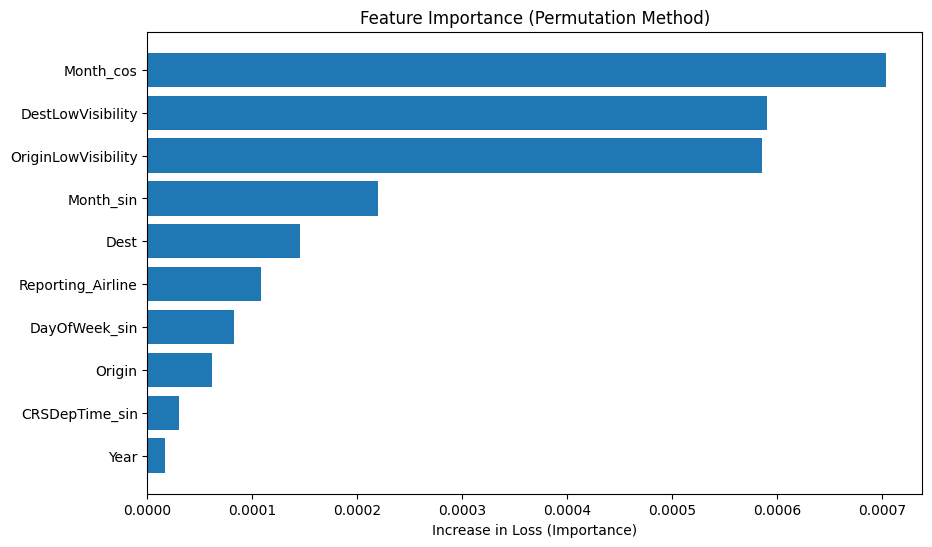


==================== Processing Training Year: 1 ====================
Starting training on 221788 samples (Validation: 55448)...
Epoch 1/100 | Train Loss: 0.6699 | Val Loss: 0.5224 (*)
Epoch 2/100 | Train Loss: 0.5146 | Val Loss: 0.4743 (*)
Epoch 3/100 | Train Loss: 0.4903 | Val Loss: 0.4707 (*)
Epoch 4/100 | Train Loss: 0.4837 | Val Loss: 0.4699 (*)
Epoch 5/100 | Train Loss: 0.4809 | Val Loss: 0.4672 (*)
Epoch 6/100 | Train Loss: 0.4793 | Val Loss: 0.4655 (*)
Epoch 7/100 | Train Loss: 0.4768 | Val Loss: 0.4648 (*)
Epoch 8/100 | Train Loss: 0.4754 | Val Loss: 0.4637 (*)
Epoch 9/100 | Train Loss: 0.4734 | Val Loss: 0.4628 (*)
Epoch 10/100 | Train Loss: 0.4722 | Val Loss: 0.4621 (*)
Epoch 11/100 | Train Loss: 0.4712 | Val Loss: 0.4615 (*)
Epoch 12/100 | Train Loss: 0.4705 | Val Loss: 0.4605 (*)
Epoch 13/100 | Train Loss: 0.4692 | Val Loss: 0.4609 (No imp. 1/5)
Epoch 14/100 | Train Loss: 0.4684 | Val Loss: 0.4597 (*)
Epoch 15/100 | Train Loss: 0.4675 | Val Loss: 0.4590 (*)
Epoch 16/100 |

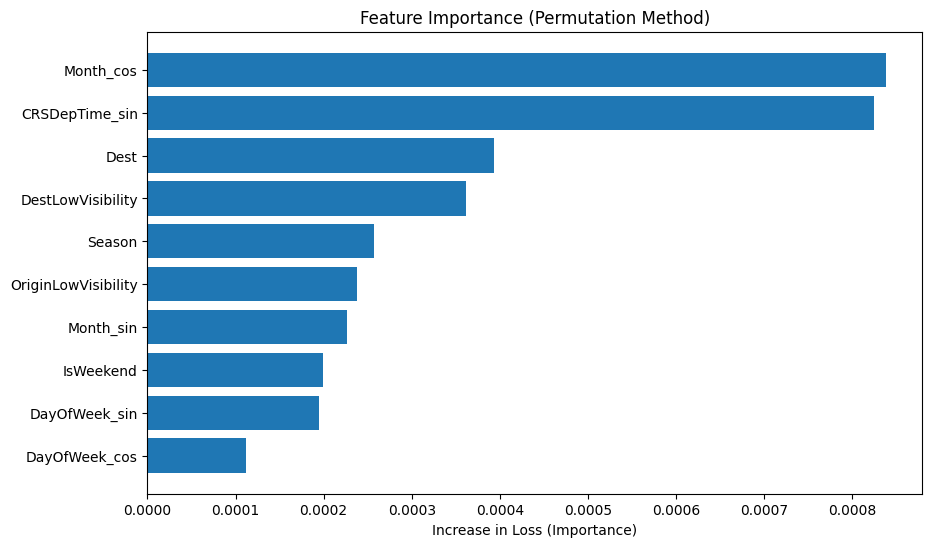


==================== Processing Training Year: 2 ====================
Starting training on 133901 samples (Validation: 33476)...
Epoch 1/100 | Train Loss: 0.5886 | Val Loss: 0.4863 (*)
Epoch 2/100 | Train Loss: 0.4307 | Val Loss: 0.3429 (*)
Epoch 3/100 | Train Loss: 0.3501 | Val Loss: 0.3246 (*)
Epoch 4/100 | Train Loss: 0.3335 | Val Loss: 0.3203 (*)
Epoch 5/100 | Train Loss: 0.3279 | Val Loss: 0.3185 (*)
Epoch 6/100 | Train Loss: 0.3248 | Val Loss: 0.3167 (*)
Epoch 7/100 | Train Loss: 0.3229 | Val Loss: 0.3162 (*)
Epoch 8/100 | Train Loss: 0.3217 | Val Loss: 0.3151 (*)
Epoch 9/100 | Train Loss: 0.3205 | Val Loss: 0.3147 (*)
Epoch 10/100 | Train Loss: 0.3201 | Val Loss: 0.3144 (*)
Epoch 11/100 | Train Loss: 0.3182 | Val Loss: 0.3130 (*)
Epoch 12/100 | Train Loss: 0.3178 | Val Loss: 0.3133 (No imp. 1/5)
Epoch 13/100 | Train Loss: 0.3166 | Val Loss: 0.3130 (No imp. 2/5)
Epoch 14/100 | Train Loss: 0.3164 | Val Loss: 0.3122 (*)
Epoch 15/100 | Train Loss: 0.3158 | Val Loss: 0.3121 (*)
Epoc

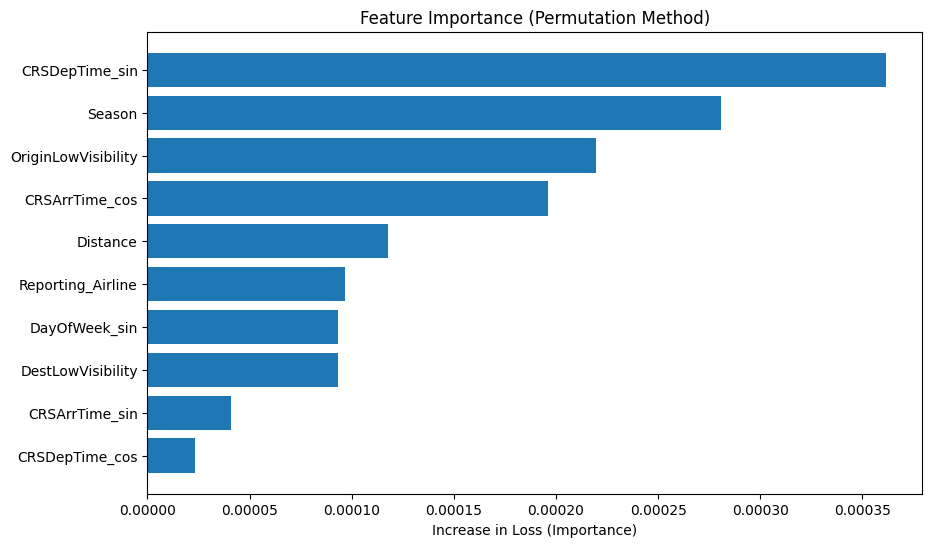


==================== Processing Training Year: 3 ====================
Starting training on 179042 samples (Validation: 44761)...
Epoch 1/100 | Train Loss: 0.6208 | Val Loss: 0.5314 (*)
Epoch 2/100 | Train Loss: 0.4920 | Val Loss: 0.4382 (*)
Epoch 3/100 | Train Loss: 0.4553 | Val Loss: 0.4327 (*)
Epoch 4/100 | Train Loss: 0.4472 | Val Loss: 0.4300 (*)
Epoch 5/100 | Train Loss: 0.4429 | Val Loss: 0.4285 (*)
Epoch 6/100 | Train Loss: 0.4402 | Val Loss: 0.4269 (*)
Epoch 7/100 | Train Loss: 0.4389 | Val Loss: 0.4262 (*)
Epoch 8/100 | Train Loss: 0.4369 | Val Loss: 0.4254 (*)
Epoch 9/100 | Train Loss: 0.4354 | Val Loss: 0.4241 (*)
Epoch 10/100 | Train Loss: 0.4350 | Val Loss: 0.4240 (*)
Epoch 11/100 | Train Loss: 0.4334 | Val Loss: 0.4233 (*)
Epoch 12/100 | Train Loss: 0.4322 | Val Loss: 0.4222 (*)
Epoch 13/100 | Train Loss: 0.4316 | Val Loss: 0.4217 (*)
Epoch 14/100 | Train Loss: 0.4302 | Val Loss: 0.4212 (*)
Epoch 15/100 | Train Loss: 0.4294 | Val Loss: 0.4211 (No imp. 1/5)
Epoch 16/100 |

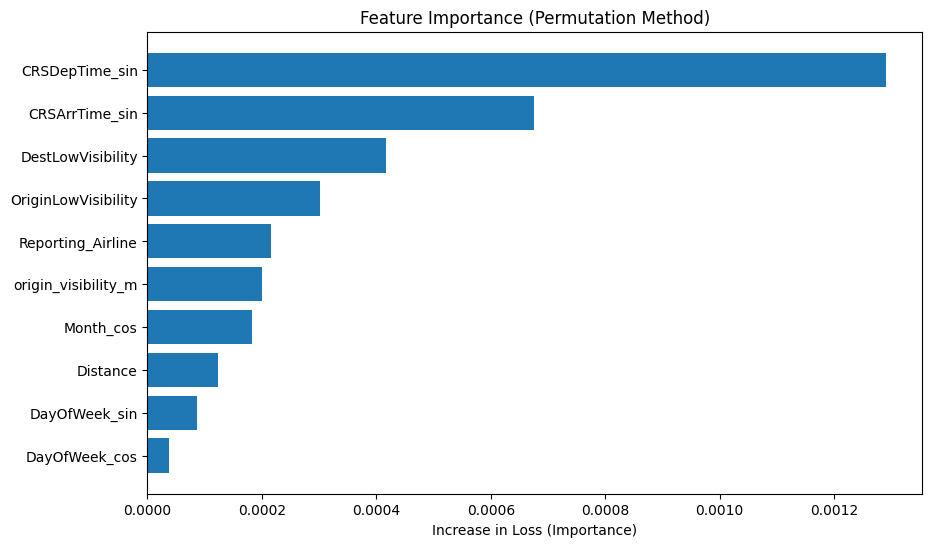


==================== Processing Training Year: 4 ====================
Starting training on 199966 samples (Validation: 49992)...
Epoch 1/100 | Train Loss: 0.6163 | Val Loss: 0.5400 (*)
Epoch 2/100 | Train Loss: 0.5285 | Val Loss: 0.4995 (*)
Epoch 3/100 | Train Loss: 0.5079 | Val Loss: 0.4928 (*)
Epoch 4/100 | Train Loss: 0.5010 | Val Loss: 0.4912 (*)
Epoch 5/100 | Train Loss: 0.4981 | Val Loss: 0.4895 (*)
Epoch 6/100 | Train Loss: 0.4958 | Val Loss: 0.4891 (*)
Epoch 7/100 | Train Loss: 0.4942 | Val Loss: 0.4887 (*)
Epoch 8/100 | Train Loss: 0.4930 | Val Loss: 0.4875 (*)
Epoch 9/100 | Train Loss: 0.4922 | Val Loss: 0.4869 (*)
Epoch 10/100 | Train Loss: 0.4909 | Val Loss: 0.4865 (*)
Epoch 11/100 | Train Loss: 0.4900 | Val Loss: 0.4857 (*)
Epoch 12/100 | Train Loss: 0.4893 | Val Loss: 0.4856 (*)
Epoch 13/100 | Train Loss: 0.4886 | Val Loss: 0.4851 (*)
Epoch 14/100 | Train Loss: 0.4883 | Val Loss: 0.4848 (*)
Epoch 15/100 | Train Loss: 0.4875 | Val Loss: 0.4844 (*)
Epoch 16/100 | Train Los

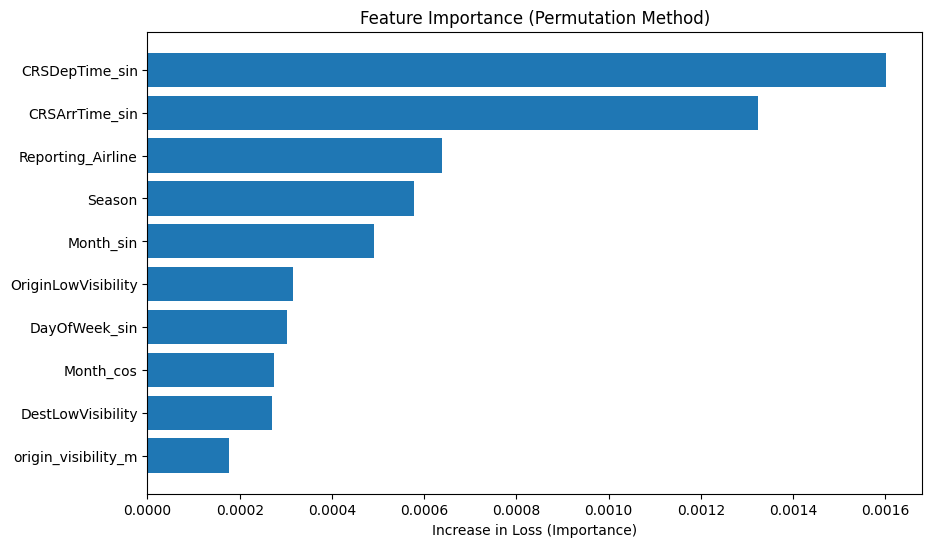


==================== Processing Training Year: 5 ====================
Starting training on 205475 samples (Validation: 51369)...
Epoch 1/100 | Train Loss: 0.6157 | Val Loss: 0.5403 (*)
Epoch 2/100 | Train Loss: 0.5190 | Val Loss: 0.4874 (*)
Epoch 3/100 | Train Loss: 0.4972 | Val Loss: 0.4817 (*)
Epoch 4/100 | Train Loss: 0.4906 | Val Loss: 0.4792 (*)
Epoch 5/100 | Train Loss: 0.4880 | Val Loss: 0.4778 (*)
Epoch 6/100 | Train Loss: 0.4854 | Val Loss: 0.4760 (*)
Epoch 7/100 | Train Loss: 0.4849 | Val Loss: 0.4755 (*)
Epoch 8/100 | Train Loss: 0.4826 | Val Loss: 0.4747 (*)
Epoch 9/100 | Train Loss: 0.4814 | Val Loss: 0.4740 (*)
Epoch 10/100 | Train Loss: 0.4808 | Val Loss: 0.4738 (*)
Epoch 11/100 | Train Loss: 0.4804 | Val Loss: 0.4744 (No imp. 1/5)
Epoch 12/100 | Train Loss: 0.4794 | Val Loss: 0.4734 (*)
Epoch 13/100 | Train Loss: 0.4780 | Val Loss: 0.4723 (*)
Epoch 14/100 | Train Loss: 0.4785 | Val Loss: 0.4725 (No imp. 1/5)
Epoch 15/100 | Train Loss: 0.4774 | Val Loss: 0.4719 (*)
Epoc

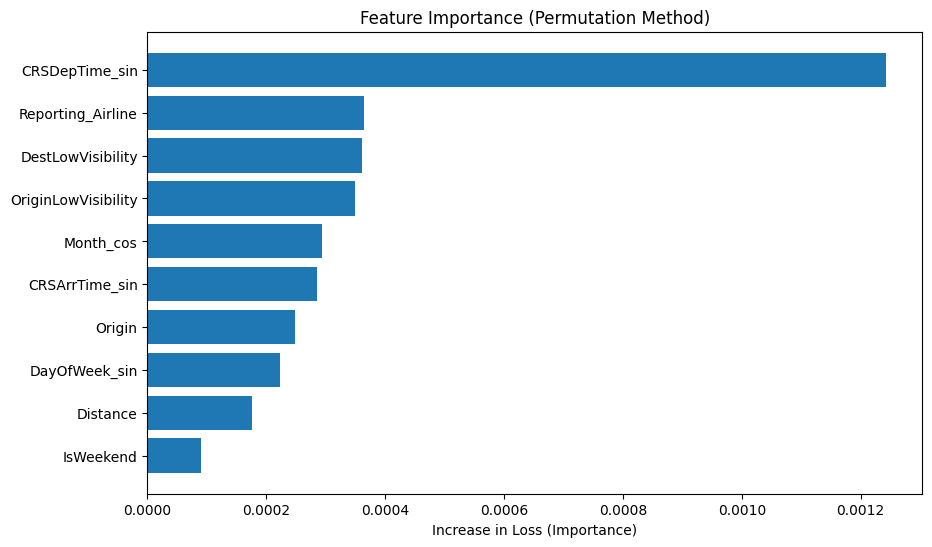


==================== Processing Training Year: 6 ====================
Starting training on 212552 samples (Validation: 53139)...
Epoch 1/100 | Train Loss: 0.6225 | Val Loss: 0.5270 (*)
Epoch 2/100 | Train Loss: 0.5236 | Val Loss: 0.4906 (*)
Epoch 3/100 | Train Loss: 0.5021 | Val Loss: 0.4882 (*)
Epoch 4/100 | Train Loss: 0.4952 | Val Loss: 0.4866 (*)
Epoch 5/100 | Train Loss: 0.4926 | Val Loss: 0.4860 (*)
Epoch 6/100 | Train Loss: 0.4907 | Val Loss: 0.4847 (*)
Epoch 7/100 | Train Loss: 0.4895 | Val Loss: 0.4842 (*)
Epoch 8/100 | Train Loss: 0.4882 | Val Loss: 0.4839 (*)
Epoch 9/100 | Train Loss: 0.4869 | Val Loss: 0.4834 (*)
Epoch 10/100 | Train Loss: 0.4865 | Val Loss: 0.4827 (*)
Epoch 11/100 | Train Loss: 0.4849 | Val Loss: 0.4823 (*)
Epoch 12/100 | Train Loss: 0.4849 | Val Loss: 0.4818 (*)
Epoch 13/100 | Train Loss: 0.4841 | Val Loss: 0.4820 (No imp. 1/5)
Epoch 14/100 | Train Loss: 0.4840 | Val Loss: 0.4814 (*)
Epoch 15/100 | Train Loss: 0.4829 | Val Loss: 0.4812 (*)
Epoch 16/100 |

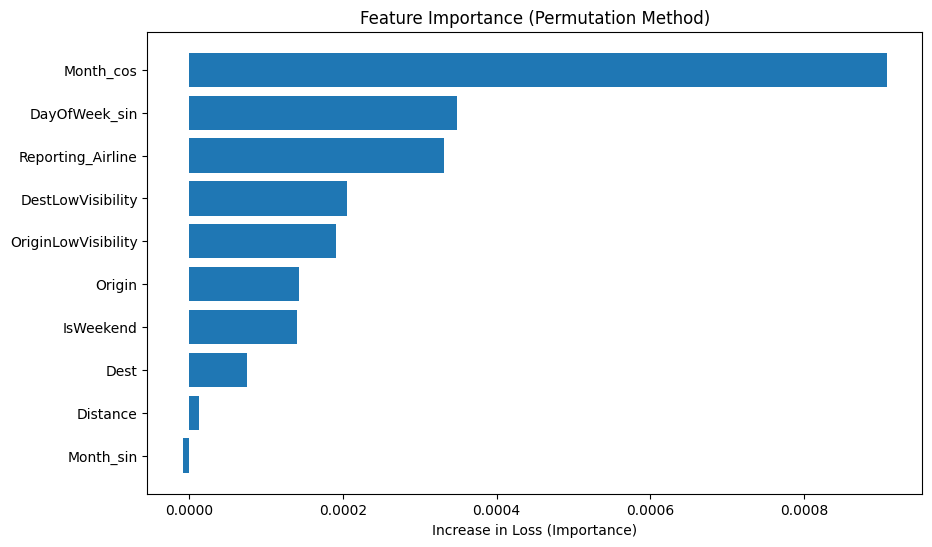


==================== Processing Training Year: 7 ====================
Starting training on 15881 samples (Validation: 3971)...
Epoch 1/100 | Train Loss: 0.7508 | Val Loss: 0.6693 (*)
Epoch 2/100 | Train Loss: 0.7071 | Val Loss: 0.6492 (*)
Epoch 3/100 | Train Loss: 0.6901 | Val Loss: 0.6321 (*)
Epoch 4/100 | Train Loss: 0.6712 | Val Loss: 0.6178 (*)
Epoch 5/100 | Train Loss: 0.6583 | Val Loss: 0.6097 (*)
Epoch 6/100 | Train Loss: 0.6464 | Val Loss: 0.5997 (*)
Epoch 7/100 | Train Loss: 0.6328 | Val Loss: 0.5873 (*)
Epoch 8/100 | Train Loss: 0.6191 | Val Loss: 0.5723 (*)
Epoch 9/100 | Train Loss: 0.6040 | Val Loss: 0.5621 (*)
Epoch 10/100 | Train Loss: 0.5933 | Val Loss: 0.5440 (*)
Epoch 11/100 | Train Loss: 0.5812 | Val Loss: 0.5318 (*)
Epoch 12/100 | Train Loss: 0.5716 | Val Loss: 0.5185 (*)
Epoch 13/100 | Train Loss: 0.5585 | Val Loss: 0.5089 (*)
Epoch 14/100 | Train Loss: 0.5508 | Val Loss: 0.4992 (*)
Epoch 15/100 | Train Loss: 0.5415 | Val Loss: 0.4937 (*)
Epoch 16/100 | Train Loss:

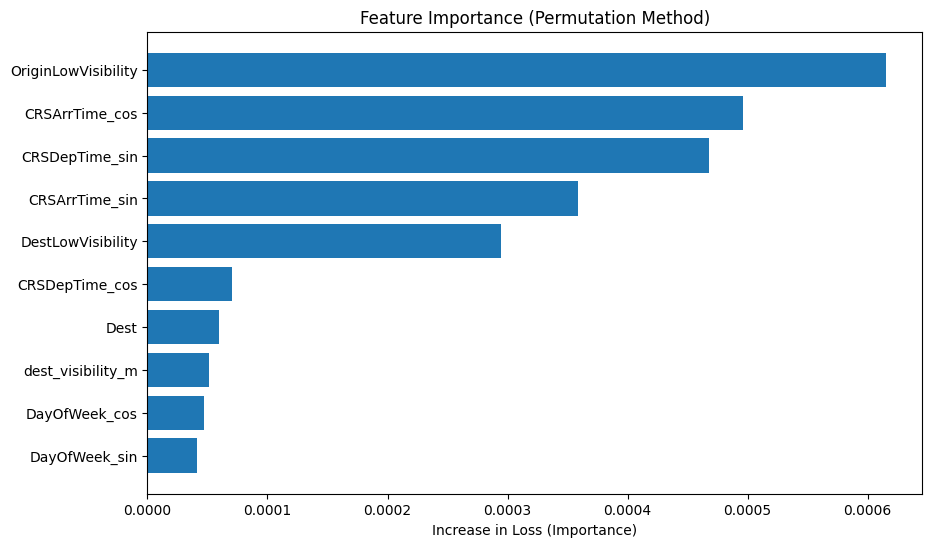


=== Final Detailed Performance ===
   Training_Year  Curr_Accuracy  Curr_ROC_AUC Next_ROC_AUC
0              0       0.812596      0.679882      0.66374
1              1       0.811395      0.684206     0.607869
2              2       0.899606      0.656288     0.577584
3              3       0.833175      0.694104     0.631655
4              4       0.791535      0.682008     0.660323
5              5       0.799629      0.689428     0.666266
6              6       0.793836      0.700059      0.63126
7              7       0.813054      0.605378          N/A


In [ ]:
import copy
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split # Ensure this is imported
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# [Previous get_all_metrics function remains the same]
def get_all_metrics(model, loader, device):
    model.eval()
    y_true_list = []
    y_prob_list = []

    with torch.no_grad():
        for x_cat, x_cont, y_target in loader:
            x_cat = x_cat.to(device)
            x_cont = x_cont.to(device)
            y_target = y_target.to(device)
            out = model(x_cat, x_cont)
            y_prob_list.append(out.cpu().numpy())
            y_true_list.append(y_target.cpu().numpy())

    y_true = np.concatenate(y_true_list).ravel()
    y_probs = np.concatenate(y_prob_list).ravel()
    y_pred = (y_probs > 0.5).astype(int)

    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, zero_division=0),
        'Recall': recall_score(y_true, y_pred, zero_division=0),
        'F1': f1_score(y_true, y_pred, zero_division=0),
        'ROC_AUC': roc_auc_score(y_true, y_probs)
    }

# --- Settings for Early Stopping ---
PATIENCE = 5       # Stop if no improvement after 5 epochs
MAX_EPOCHS = 100    # Maximum epochs if early stopping doesn't trigger
MIN_DELTA = 0.0001 # Minimum change to qualify as an improvement

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
results = []

for i, current_year in enumerate(years):
    print(f"\n{'='*20} Processing Training Year: {current_year} {'='*20}")

    # --- A. Split Data by Year ---
    year_df = df_all[df_all['Year'] == current_year]

    # Check for next year data (for temporal generalization test)
    next_year = current_year + 1
    has_next_year = next_year in years
    next_year_df = df_all[df_all['Year'] == next_year] if has_next_year else None

    # --- B. Create Train / Validation / Test Splits ---
    # 1. First split: Separate out 20% for FINAL Testing
    X_temp, X_test_curr, y_temp, y_test_curr = train_test_split(
        year_df[cat_cols + cont_cols],
        year_df[target_col],
        test_size=0.2,
        random_state=42
    )

    # 2. Second split: Split the remaining 80% into Train (80%) and Validation (20%)
    # Effective Split: Train (~64%), Val (~16%), Test (20%)
    X_train_curr, X_val_curr, y_train_curr, y_val_curr = train_test_split(
        X_temp,
        y_temp,
        test_size=0.2,
        random_state=42
    )

    # --- C. Scale Data (Fit on TRAIN only to avoid leakage) ---
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_curr[cont_cols])
    X_val_scaled = scaler.transform(X_val_curr[cont_cols])  # Transform Val
    X_test_scaled = scaler.transform(X_test_curr[cont_cols]) # Transform Test

    # --- D. Create DataLoaders ---
    # Train Loader
    train_ds = FlightDataset(
        pd.concat([X_train_curr[cat_cols].reset_index(drop=True),
                   pd.DataFrame(X_train_scaled, columns=cont_cols)], axis=1),
        y_train_curr, cat_cols, cont_cols
    )
    # Validation Loader
    val_ds = FlightDataset(
        pd.concat([X_val_curr[cat_cols].reset_index(drop=True),
                   pd.DataFrame(X_val_scaled, columns=cont_cols)], axis=1),
        y_val_curr, cat_cols, cont_cols
    )
    # Test Loader
    test_ds = FlightDataset(
        pd.concat([X_test_curr[cat_cols].reset_index(drop=True),
                   pd.DataFrame(X_test_scaled, columns=cont_cols)], axis=1),
        y_test_curr, cat_cols, cont_cols
    )

    train_loader = DataLoader(train_ds, batch_size=1024, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=1024, shuffle=False)
    test_loader = DataLoader(test_ds, batch_size=1024, shuffle=False)

    # --- E. Initialize Model ---
    model = FlightDelayMLP(embedding_sizes, n_cont=len(cont_cols)).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.BCELoss()

    # --- F. Training Loop with Early Stopping ---
    best_val_loss = float('inf')
    counter = 0
    best_model_wts = copy.deepcopy(model.state_dict())

    print(f"Starting training on {len(train_ds)} samples (Validation: {len(val_ds)})...")

    for epoch in range(MAX_EPOCHS):
        # 1. Training Step
        model.train()
        train_loss = 0
        for x_cat, x_cont, y_t in train_loader:
            x_cat, x_cont, y_t = x_cat.to(device), x_cont.to(device), y_t.to(device)
            optimizer.zero_grad()
            out = model(x_cat, x_cont)
            loss = criterion(out, y_t)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)

        # 2. Validation Step
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x_cat, x_cont, y_t in val_loader:
                x_cat, x_cont, y_t = x_cat.to(device), x_cont.to(device), y_t.to(device)
                out = model(x_cat, x_cont)
                loss = criterion(out, y_t)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)

        print(f"Epoch {epoch+1}/{MAX_EPOCHS} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}", end=" ")

        # 3. Early Stopping Check
        if avg_val_loss < (best_val_loss - MIN_DELTA):
            best_val_loss = avg_val_loss
            best_model_wts = copy.deepcopy(model.state_dict()) # Save best model
            counter = 0 # Reset counter
            print("(*)") # Indicator of improvement
        else:
            counter += 1
            print(f"(No imp. {counter}/{PATIENCE})")
            if counter >= PATIENCE:
                print(f"Early stopping triggered at epoch {epoch+1}!")
                break

    # Load the best model weights before final evaluation
    model.load_state_dict(best_model_wts)

    # --- G. Final Evaluation on TEST Set (Unseen data) ---
    m_curr = get_all_metrics(model, test_loader, device)
    print(f"[{current_year} FINAL TEST] Acc: {m_curr['Accuracy']:.4f} | F1: {m_curr['F1']:.4f} | AUC: {m_curr['ROC_AUC']:.4f}")

    # --- H. Evaluate on NEXT Year ---
    m_next = {k: "N/A" for k in m_curr.keys()}

    if has_next_year:
        X_next_cont = scaler.transform(next_year_df[cont_cols])

        next_ds = FlightDataset(
            pd.concat([next_year_df[cat_cols].reset_index(drop=True),
                       pd.DataFrame(X_next_cont, columns=cont_cols)], axis=1),
            next_year_df[target_col], cat_cols, cont_cols
        )
        next_loader = DataLoader(next_ds, batch_size=1024, shuffle=False)
        m_next = get_all_metrics(model, next_loader, device)
        print(f"[{next_year} GEN]        Acc: {m_next['Accuracy']:.4f} | F1: {m_next['F1']:.4f} | AUC: {m_next['ROC_AUC']:.4f}")

    # Store results
    row = {'Training_Year': current_year, 'Best_Val_Loss': best_val_loss}
    for k, v in m_curr.items(): row[f'Curr_{k}'] = v
    for k, v in m_next.items(): row[f'Next_{k}'] = v
    results.append(row)

    importances = get_permutation_importance(
    model,
    X_test[cat_cols],
    X_test[cont_cols],   # pass DF or .values; both work now
    y_test,
    cat_cols,
    cont_cols,
    device=device,
    use_logits=True      # set False only if model output is already sigmoid probs
    )

    # Plotting
    sorted_imp = dict(sorted(importances.items(), key=lambda item: item[1], reverse=True))
    plt.figure(figsize=(10, 6))
    plt.barh(list(sorted_imp.keys())[:10], list(sorted_imp.values())[:10]) # Top 10
    plt.xlabel("Increase in Loss (Importance)")
    plt.title("Feature Importance (Permutation Method)")
    plt.gca().invert_yaxis()
    plt.show()

results_df = pd.DataFrame(results)
print("\n=== Final Detailed Performance ===")
print(results_df[['Training_Year', 'Curr_Accuracy', 'Curr_ROC_AUC', 'Next_ROC_AUC']])


=== Year-over-Year Performance Analysis ===
   Training_Year  Best_Val_Loss  Curr_Accuracy  Curr_Precision  Curr_Recall  \
0           2018       0.459484       0.812596        0.658863     0.015476   
1           2019       0.452111       0.811395        0.620637     0.030912   
2           2020       0.309672       0.899606        1.000000     0.000238   
3           2021       0.414293       0.833175        0.638365     0.021545   
4           2022       0.479569       0.791535        0.607375     0.021332   
5           2023       0.467174       0.799629        0.632653     0.037938   
6           2024       0.473146       0.793836        0.610206     0.040440   
7           2025       0.473070       0.813054        0.400000     0.002157   

    Curr_F1  Curr_ROC_AUC Next_Accuracy Next_Precision Next_Recall   Next_F1  \
0  0.030243      0.679882      0.810394       0.595699    0.020937  0.040452   
1  0.058891      0.684206      0.898863       0.263308    0.013406  0.025513   
2  

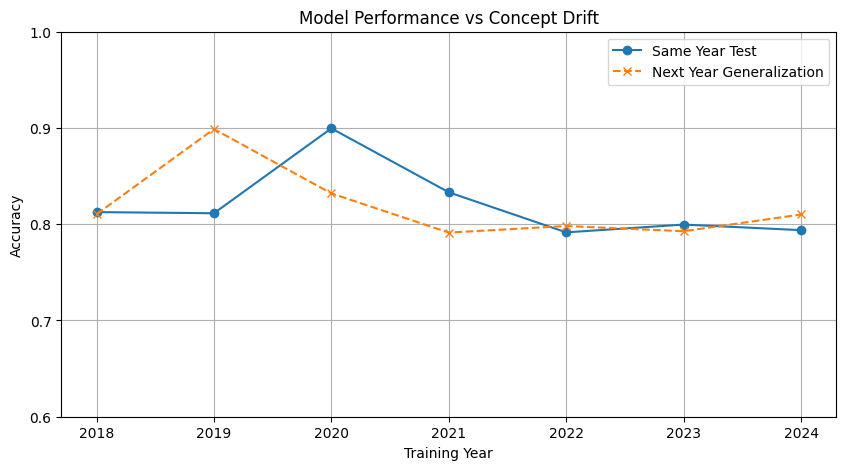

In [ ]:
results_df = pd.DataFrame(results)
print("\n=== Year-over-Year Performance Analysis ===")
results_df['Training_Year'] = (
    pd.to_numeric(results_df['Training_Year'], errors='coerce')
      .astype('Int64')  # allows <NA>
      + 2018
)
print(results_df)

# Optional: Visualize the drift
if len(results_df) > 1 and results_df['Next_Accuracy'].iloc[0] != "N/A":
    plt.figure(figsize=(10, 5))
    valid_results = results_df[results_df['Next_Accuracy'] != "N/A"]

    plt.plot(valid_results['Training_Year'].astype(str), valid_results['Curr_Accuracy'],
             marker='o', label='Same Year Test')
    plt.plot(valid_results['Training_Year'].astype(str), valid_results['Next_Accuracy'],
             marker='x', linestyle='--', label='Next Year Generalization')

    plt.title("Model Performance vs Concept Drift")
    plt.ylabel("Accuracy")
    plt.xlabel("Training Year")
    plt.ylim(0.6, 1)              # <-- y-axis from 0 to 1
    plt.yticks(np.linspace(0.6, 1, 5))  # optional: 0.0, 0.1, ..., 1.0

    plt.legend()
    plt.grid(True)
    plt.show()

In [1]:
# import numpy as np

# # example: rolling AUC over time-ordered data
# from sklearn.metrics import roc_auc_score

# window = 5000
# aucs = []
# for start in range(0, len(y_true)-window+1, window):
#     end = start + window
#     aucs.append(roc_auc_score(y_true[start:end], y_probs[start:end]))

# # look for drops vs early baseline
# baseline = np.mean(aucs[:3])
# drift_flags = [a < baseline - 0.05 for a in aucs]  # choose tolerance

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

def detect_drift_adversarial(df_reference, df_current, cols_to_check):
    # 1. Label the data
    df_reference['is_new'] = 0
    df_current['is_new'] = 1

    # 2. Combine
    df_combined = pd.concat([df_reference, df_current], axis=0).sample(frac=1)

    # 3. Train a simple classifier (Random Forest is usually sufficient)
    X = df_combined[cols_to_check]
    y = df_combined['is_new']

    # Split specifically for this detection task
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    clf = RandomForestClassifier(n_estimators=50, max_depth=5)
    clf.fit(X_train, y_train)

    # 4. Check AUC
    probs = clf.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, probs)

    print(f"Drift Detection AUC: {auc:.4f}")
    if auc > 0.7:
        print("!! SIGNIFICANT DRIFT DETECTED !!")
        # Optional: Show which features caused the drift
        importances = pd.Series(clf.feature_importances_, index=cols_to_check)
        print(importances.sort_values(ascending=False).head(3))
    else:
        print("Data distribution is stable.")
    return auc, probs

In [ ]:
# Example Usage:
# detect_drift_adversarial(df_2018, df_2019, cont_cols)
for i in df['Year'].unique():
    if i != df['Year'].max():
        detect_drift_adversarial(df[df['Year'] == i], df[df['Year'] == i+1], cont_cols)


/tmp/ipython-input-730375840.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reference['is_new'] = 0
/tmp/ipython-input-730375840.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_current['is_new'] = 1


Drift Detection AUC: 0.5675
Data distribution is stable.


/tmp/ipython-input-730375840.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reference['is_new'] = 0
/tmp/ipython-input-730375840.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_current['is_new'] = 1


Drift Detection AUC: 0.6381
Data distribution is stable.


/tmp/ipython-input-730375840.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reference['is_new'] = 0
/tmp/ipython-input-730375840.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_current['is_new'] = 1


Drift Detection AUC: 0.6520
Data distribution is stable.


/tmp/ipython-input-730375840.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reference['is_new'] = 0
/tmp/ipython-input-730375840.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_current['is_new'] = 1


Drift Detection AUC: 0.5786
Data distribution is stable.


/tmp/ipython-input-730375840.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reference['is_new'] = 0
/tmp/ipython-input-730375840.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_current['is_new'] = 1


Drift Detection AUC: 0.5753
Data distribution is stable.


/tmp/ipython-input-730375840.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reference['is_new'] = 0
/tmp/ipython-input-730375840.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_current['is_new'] = 1


Drift Detection AUC: 0.6026
Data distribution is stable.


/tmp/ipython-input-730375840.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reference['is_new'] = 0
/tmp/ipython-input-730375840.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_current['is_new'] = 1


Drift Detection AUC: 0.9719
!! SIGNIFICANT DRIFT DETECTED !!
Month_cos        0.405649
Month_sin        0.328232
origin_temp_c    0.129344
dtype: float64



Checking period: 0 vs 1
Drift Detection AUC: 0.5672
Data distribution is relatively stable.

Checking period: 1 vs 2
Drift Detection AUC: 0.6402
Data distribution is relatively stable.

Checking period: 2 vs 3
Drift Detection AUC: 0.6507
Data distribution is relatively stable.

Checking period: 3 vs 4
Drift Detection AUC: 0.5789
Data distribution is relatively stable.

Checking period: 4 vs 5
Drift Detection AUC: 0.5712
Data distribution is relatively stable.

Checking period: 5 vs 6
Drift Detection AUC: 0.5996
Data distribution is relatively stable.


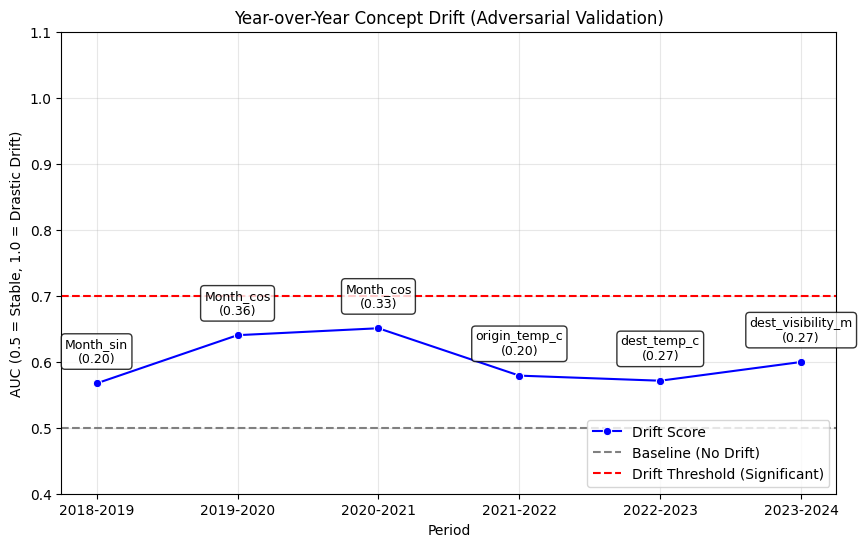

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

def detect_drift_adversarial(df_reference, df_current, cols_to_check):
    """
    Trains a classifier to distinguish between reference and current data.
    Returns AUC (drift score) and Feature Importances.
    """
    # 1. Label the data (Use .copy() to avoid SettingWithCopy warnings on original df)
    df_ref = df_reference.copy()
    df_curr = df_current.copy()

    df_ref['is_new'] = 0
    df_curr['is_new'] = 1

    # 2. Combine
    df_combined = pd.concat([df_ref, df_curr], axis=0).sample(frac=1, random_state=42)

    # 3. Train a simple classifier
    X = df_combined[cols_to_check]
    y = df_combined['is_new']

    # Split specifically for this detection task
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    clf = RandomForestClassifier(n_estimators=50, max_depth=5, random_state=42)
    clf.fit(X_train, y_train)

    # 4. Check AUC
    probs = clf.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, probs)

    # Calculate importances (Must be done every time to return them)
    importances = pd.Series(clf.feature_importances_, index=cols_to_check)

    print(f"Drift Detection AUC: {auc:.4f}")
    if auc > 0.7:
        print("!! SIGNIFICANT DRIFT DETECTED !!")
        print(importances.sort_values(ascending=False).head(3))
    else:
        print("Data distribution is relatively stable.")

    # FIX: Return importances instead of probs to match the loop below
    return auc, importances

# --- Main Execution ---

# 1. Capture Results in a List
results = []
years = sorted(df['Year'].unique())

for i in range(len(years) - 1 - 1):
    y_ref = years[i]
    y_curr = years[i+1]

    print(f"\nChecking period: {y_ref} vs {y_curr}")

    # Run detection function
    auc, imps = detect_drift_adversarial(
        df[df['Year'] == y_ref],
        df[df['Year'] == y_curr],
        cont_cols
    )

    # Sort and store top feature
    imps_sorted = imps.sort_values(ascending=False)
    top_feat = imps_sorted.index[0]
    top_val = imps_sorted.iloc[0]

    results.append({
        'Period': f"{y_ref+2018}-{y_curr+2018}",
        'AUC': auc,
        'Top_Feature': top_feat,
        'Importance': top_val
    })

results_df = pd.DataFrame(results)

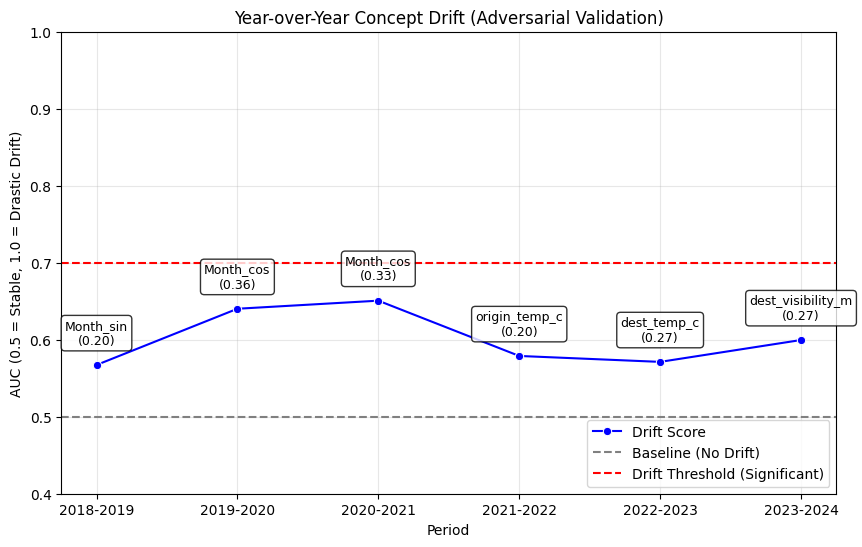

In [ ]:

# 2. Plotting
plt.figure(figsize=(10, 6))

sns.lineplot(data=results_df, x='Period', y='AUC', marker='o', color='blue', label='Drift Score')

# Add Threshold Lines
plt.axhline(0.5, color='gray', linestyle='--', label='Baseline (No Drift)')
plt.axhline(0.7, color='red', linestyle='--', label='Drift Threshold (Significant)')

# Annotate the points
for i, row in results_df.iterrows():
    plt.annotate(
        f"{row['Top_Feature']}\n({row['Importance']:.2f})",
        (row['Period'], row['AUC']),
        xytext=(0, 15), textcoords='offset points', ha='center',
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.8),
        fontsize=9
    )

plt.title("Year-over-Year Concept Drift (Adversarial Validation)")
plt.ylabel("AUC (0.5 = Stable, 1.0 = Drastic Drift)")
plt.ylim(0.4, 1.0) # Added some headroom for annotations
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()